# Generative Adversarial Network (GAN) using Tensorflow
A GAN trained on MNIST dataset to generate B/W handwritten digits. Both the Discriminator (C2 - C4 - C8), and the Generator (C32 - C16 - C8) are simple CNNs. The Generator latent space is 64 dimensional.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Load the `MNIST` dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Preprocessing
Rescaling the images to $[0, 1]$ and reshape to HWC format

In [3]:
def pre_process_imgs(img):
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    img = tf.reshape(img, (28, 28, 1))
    return img

# Dataset
Define a dataset object

In [4]:
MNIST_dataset = tf.data.Dataset.from_tensor_slices(x_train)
MNIST_dataset = MNIST_dataset.map(pre_process_imgs).batch(128)

## Discriminator
Discriminator takes in a 28x28 images in and return a 0 for fake and 1 for real images. The weights are initiated using `HeUniform` for weights and zeros for the biases.

In [5]:
class MnistDisc(tf.keras.Model):
    def __init__(self):
        super(MnistDisc, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, padding='same',
         use_bias=True, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv2 = tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
         use_bias=True, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        self.conv3 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='valid',
         use_bias=True, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1, use_bias=True)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        return self.fc1(x)

## Generator
Generator takes in a 64x1 vector and outputs a 28x28 image. The weights are initiated using `HeUniform` for weights and zeros for the biases.

In [6]:
class MnistGen(tf.keras.Model):
    def __init__(self):
        super(MnistGen, self).__init__()
        self.fc1 = tf.keras.layers.Dense(1568, use_bias=True, kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros') # 7*7*32 = 1568
        self.ac1 = tf.keras.layers.LeakyReLU(0.2)
        self.usample1 = tf.keras.layers.UpSampling2D(size=2)
        self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same',
            use_bias=True, kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros')
        self.ac2 = tf.keras.layers.LeakyReLU(0.2)
        self.usample2 = tf.keras.layers.UpSampling2D(size=2)
        self.conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same',
            use_bias=True, kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros')
        self.ac3 = tf.keras.layers.LeakyReLU(0.2)
        self.conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same',
            use_bias=True, activation = 'sigmoid', kernel_initializer=tf.keras.initializers.HeUniform(), bias_initializer='zeros')

    def call(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = tf.reshape(x, [-1, 7, 7, 32])
        x = self.usample1(x)
        x = self.conv1(x)
        x = self.ac2(x)
        x = self.usample2(x)
        x = self.conv2(x)
        x = self.ac3(x)
        return self.conv3(x)

# GAN
Complete GAN model. Both discriminator and generator are using `Adam` optimizers. Discriminator is trying to minimize a binary cross-entropy loss on a set of fake and real images while the generator is trying to fool the discriminator by minimizing a binary cross-entropy loss on the fake images with labels of 1.

In [7]:
class MnistGAN(tf.keras.Model):
    def __init__(self, latent_dim):
        super(MnistGAN, self).__init__()
        self.gen = MnistGen()
        self.disc = MnistDisc()
        self.latent_dim = latent_dim
        self.d_loss_rep = {}
        self.g_loss_rep = {}

    def _disc_loss(self, data, z):
        gen_data = self.disc(self.gen(z))
        gen_label = tf.zeros((gen_data.shape[0], 1))
        real_data = self.disc(data)
        real_label = tf.ones((real_data.shape[0], 1))
        labels = tf.concat([gen_label, real_label], axis=0)
        data = tf.concat([gen_data, real_data], axis=0)
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='sum')(labels, data)/data.shape[0]

    def _gen_loss(self, z):
        gen_data = self.disc(self.gen(z))
        gen_label = tf.ones((gen_data.shape[0], 1))
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='sum')(gen_label, gen_data)/gen_data.shape[0]
    
    def _train_step(self, dopt, gopt, data, z):
        # step disc
        with tf.GradientTape() as d_tape:
            d_loss = self._disc_loss(data, z)
        d_grads = d_tape.gradient(d_loss, self.disc.trainable_variables)
        dopt.apply_gradients(zip(d_grads, self.disc.trainable_variables))
        
        #step gen
        with tf.GradientTape() as g_tape:
            g_loss = self._gen_loss(z)
        g_grads = g_tape.gradient(g_loss, self.gen.trainable_variables)
        gopt.apply_gradients(zip(g_grads, self.gen.trainable_variables))

        return d_loss, g_loss
    
    def train(self, data, epochs):
        dopt = tf.keras.optimizers.Adam(learning_rate=0.0002, decay=0.0)
        gopt = tf.keras.optimizers.Adam(learning_rate=0.0002, decay=0.0)
        for epoch in range(epochs):
            for id, batch in enumerate(data):
                z = tf.random.normal((batch.shape[0], self.latent_dim))
                d_loss, g_loss = self._train_step(dopt, gopt, batch, z)
                if id == 0 and epoch % 10 == 0:
                    test_img = self.gen(z)[0:64, ...]
                    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
                    for i in range(8):
                        for j in range(8):
                            axs[i][j].imshow(test_img[i*8+j, ..., 0], cmap='gray')
                            axs[i][j].axis('off')
                    plt.show()

            
            print(f'epoch: {epoch}, d_loss: {d_loss}, g_loss: {g_loss}')
            self.d_loss_rep[epoch] = d_loss
            self.g_loss_rep[epoch] = g_loss
        return None

    def plot_losses(self):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot(list(self.d_loss_rep.keys()), list(self.d_loss_rep.values()), color='b', lw=3, label='Discriminator Loss')
        ax.plot(list(self.g_loss_rep.keys()), list(self.g_loss_rep.values()), color='r', lw=3, label='Generator Loss')
        ax.legend()
        plt.show()
        return None

## Train
Create an instance of `MnistGAN` and train for 100 epochs

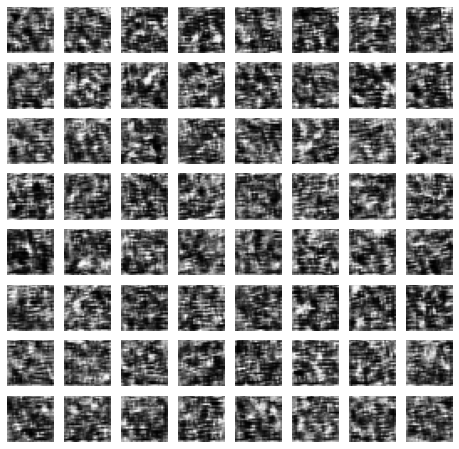

epoch: 0, d_loss: 0.7238345146179199, g_loss: 0.7284703850746155
epoch: 1, d_loss: 0.701529324054718, g_loss: 0.7146415710449219
epoch: 2, d_loss: 0.6943690776824951, g_loss: 0.6991655230522156
epoch: 3, d_loss: 0.6631397008895874, g_loss: 0.7078658938407898
epoch: 4, d_loss: 0.6544517874717712, g_loss: 0.7208657264709473
epoch: 5, d_loss: 0.6223548054695129, g_loss: 0.7964858412742615
epoch: 6, d_loss: 0.6290373206138611, g_loss: 0.8147175908088684
epoch: 7, d_loss: 0.6336502432823181, g_loss: 0.7899002432823181
epoch: 8, d_loss: 0.5877106785774231, g_loss: 0.8343667984008789
epoch: 9, d_loss: 0.6022224426269531, g_loss: 0.7999719977378845


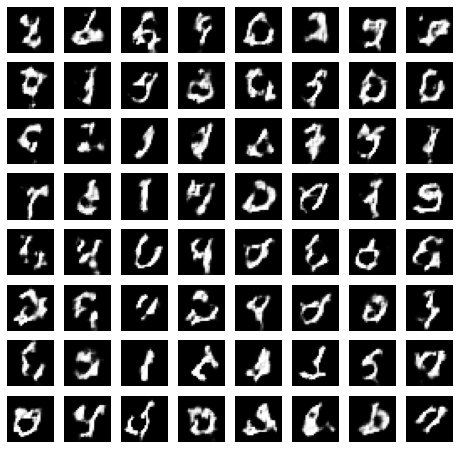

epoch: 10, d_loss: 0.616412878036499, g_loss: 0.7548126578330994
epoch: 11, d_loss: 0.6130055785179138, g_loss: 0.7360659241676331
epoch: 12, d_loss: 0.6087707877159119, g_loss: 0.7618513703346252
epoch: 13, d_loss: 0.6121334433555603, g_loss: 0.7584312558174133
epoch: 14, d_loss: 0.6270583868026733, g_loss: 0.7591922283172607
epoch: 15, d_loss: 0.647197961807251, g_loss: 0.738488495349884
epoch: 16, d_loss: 0.6392850279808044, g_loss: 0.7618494629859924
epoch: 17, d_loss: 0.6565794348716736, g_loss: 0.750653088092804
epoch: 18, d_loss: 0.6698521971702576, g_loss: 0.7141533493995667
epoch: 19, d_loss: 0.6422894597053528, g_loss: 0.7602558135986328


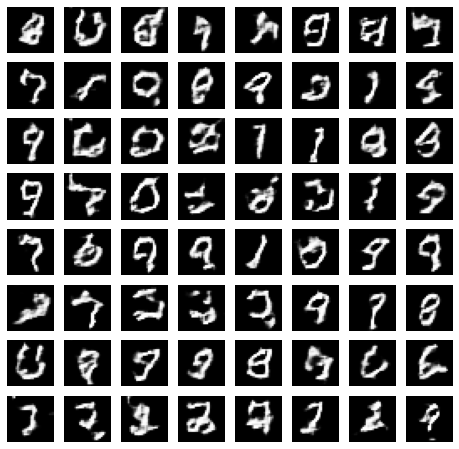

epoch: 20, d_loss: 0.6673724055290222, g_loss: 0.7261020541191101
epoch: 21, d_loss: 0.6664403080940247, g_loss: 0.7303516268730164
epoch: 22, d_loss: 0.6697811484336853, g_loss: 0.6969682574272156
epoch: 23, d_loss: 0.6604577898979187, g_loss: 0.7252784371376038
epoch: 24, d_loss: 0.6469259262084961, g_loss: 0.7374013066291809
epoch: 25, d_loss: 0.6753748059272766, g_loss: 0.6885054111480713
epoch: 26, d_loss: 0.6688414216041565, g_loss: 0.6916365027427673
epoch: 27, d_loss: 0.6690052151679993, g_loss: 0.7062111496925354
epoch: 28, d_loss: 0.6769507527351379, g_loss: 0.7011142373085022
epoch: 29, d_loss: 0.68143630027771, g_loss: 0.7009523510932922


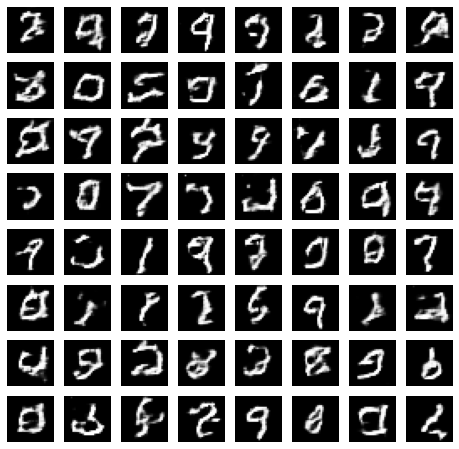

epoch: 30, d_loss: 0.6748355031013489, g_loss: 0.6901445388793945
epoch: 31, d_loss: 0.6771153807640076, g_loss: 0.7059945464134216
epoch: 32, d_loss: 0.6721082329750061, g_loss: 0.7100492119789124
epoch: 33, d_loss: 0.6836830973625183, g_loss: 0.692341148853302
epoch: 34, d_loss: 0.6861724257469177, g_loss: 0.6886642575263977
epoch: 35, d_loss: 0.6843625903129578, g_loss: 0.6967857480049133
epoch: 36, d_loss: 0.6756523251533508, g_loss: 0.7196054458618164
epoch: 37, d_loss: 0.6868074536323547, g_loss: 0.6931974291801453
epoch: 38, d_loss: 0.6801655292510986, g_loss: 0.7164399027824402
epoch: 39, d_loss: 0.6610092520713806, g_loss: 0.7355308532714844


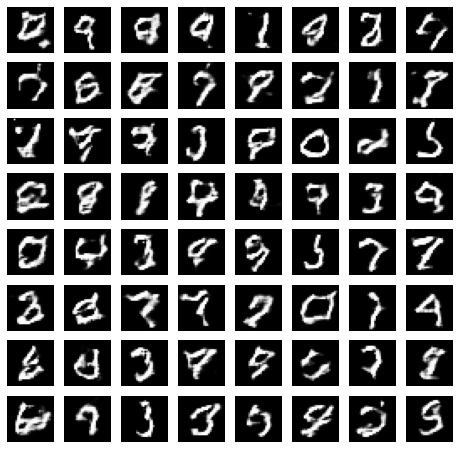

epoch: 40, d_loss: 0.6808950304985046, g_loss: 0.6985824108123779
epoch: 41, d_loss: 0.6628711223602295, g_loss: 0.7369769215583801
epoch: 42, d_loss: 0.66778165102005, g_loss: 0.7197621464729309
epoch: 43, d_loss: 0.6689260005950928, g_loss: 0.7267360687255859
epoch: 44, d_loss: 0.661512553691864, g_loss: 0.7467671036720276
epoch: 45, d_loss: 0.6567816138267517, g_loss: 0.7273361086845398
epoch: 46, d_loss: 0.654371976852417, g_loss: 0.7535223364830017
epoch: 47, d_loss: 0.6421753168106079, g_loss: 0.7639711499214172
epoch: 48, d_loss: 0.6373404860496521, g_loss: 0.7687918543815613
epoch: 49, d_loss: 0.651864767074585, g_loss: 0.7479028105735779


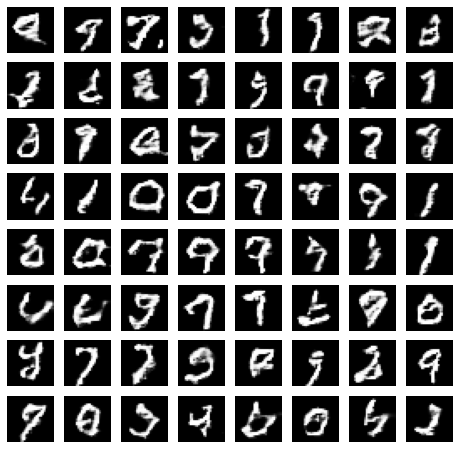

epoch: 50, d_loss: 0.6361426711082458, g_loss: 0.7639706134796143
epoch: 51, d_loss: 0.6515280604362488, g_loss: 0.7415058612823486
epoch: 52, d_loss: 0.6250515580177307, g_loss: 0.7825124263763428
epoch: 53, d_loss: 0.6281746625900269, g_loss: 0.7959434390068054
epoch: 54, d_loss: 0.6433202624320984, g_loss: 0.7414620518684387
epoch: 55, d_loss: 0.6399796605110168, g_loss: 0.7754811644554138
epoch: 56, d_loss: 0.6560584306716919, g_loss: 0.7489829659461975
epoch: 57, d_loss: 0.6497380137443542, g_loss: 0.7470949292182922
epoch: 58, d_loss: 0.652633011341095, g_loss: 0.744544506072998
epoch: 59, d_loss: 0.6530842185020447, g_loss: 0.7641201019287109


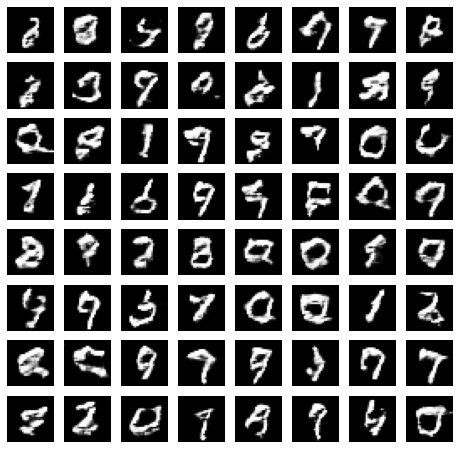

epoch: 60, d_loss: 0.655240535736084, g_loss: 0.7421019077301025
epoch: 61, d_loss: 0.6444123387336731, g_loss: 0.7668854594230652
epoch: 62, d_loss: 0.6661742925643921, g_loss: 0.7353188395500183
epoch: 63, d_loss: 0.6690294146537781, g_loss: 0.7417480945587158
epoch: 64, d_loss: 0.6816117763519287, g_loss: 0.7239078879356384
epoch: 65, d_loss: 0.6534308791160583, g_loss: 0.7907822728157043
epoch: 66, d_loss: 0.6516158580780029, g_loss: 0.778735876083374
epoch: 67, d_loss: 0.6618373990058899, g_loss: 0.7604555487632751
epoch: 68, d_loss: 0.655267059803009, g_loss: 0.7462345957756042
epoch: 69, d_loss: 0.6764364242553711, g_loss: 0.7480583190917969


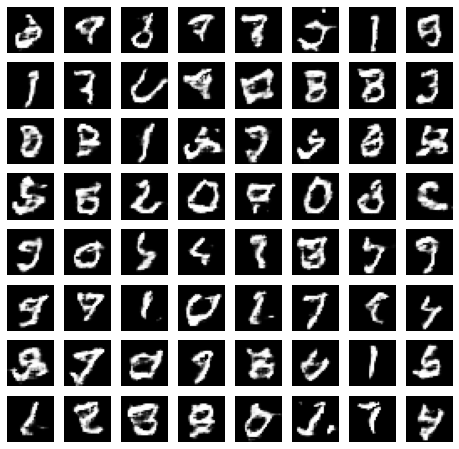

epoch: 70, d_loss: 0.6676508784294128, g_loss: 0.7554688453674316
epoch: 71, d_loss: 0.6548336744308472, g_loss: 0.7769381999969482
epoch: 72, d_loss: 0.6661603450775146, g_loss: 0.7458780407905579
epoch: 73, d_loss: 0.6700102686882019, g_loss: 0.7465767860412598
epoch: 74, d_loss: 0.6730950474739075, g_loss: 0.7521535754203796
epoch: 75, d_loss: 0.6541398167610168, g_loss: 0.7795705199241638
epoch: 76, d_loss: 0.6504581570625305, g_loss: 0.7598059773445129
epoch: 77, d_loss: 0.6794928908348083, g_loss: 0.7398902773857117
epoch: 78, d_loss: 0.661970317363739, g_loss: 0.7811320424079895
epoch: 79, d_loss: 0.6693889498710632, g_loss: 0.7733643651008606


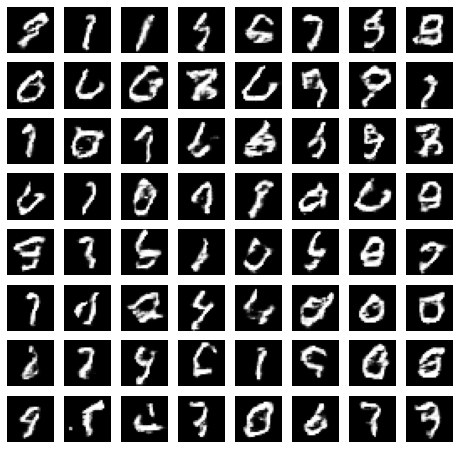

epoch: 80, d_loss: 0.6915176510810852, g_loss: 0.7341757416725159
epoch: 81, d_loss: 0.6759828925132751, g_loss: 0.7630408406257629
epoch: 82, d_loss: 0.6727917790412903, g_loss: 0.7541458010673523
epoch: 83, d_loss: 0.6943784356117249, g_loss: 0.7182620167732239
epoch: 84, d_loss: 0.6763684749603271, g_loss: 0.7373619079589844
epoch: 85, d_loss: 0.6813992857933044, g_loss: 0.750034749507904
epoch: 86, d_loss: 0.665840744972229, g_loss: 0.7534216046333313
epoch: 87, d_loss: 0.6704095005989075, g_loss: 0.7583460807800293
epoch: 88, d_loss: 0.6844847202301025, g_loss: 0.7444443106651306
epoch: 89, d_loss: 0.678978443145752, g_loss: 0.7592818737030029


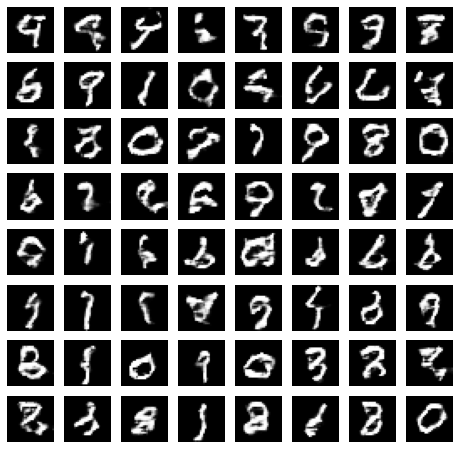

epoch: 90, d_loss: 0.6808081269264221, g_loss: 0.6973910331726074
epoch: 91, d_loss: 0.6698547005653381, g_loss: 0.7098619341850281
epoch: 92, d_loss: 0.6837511658668518, g_loss: 0.6929098963737488
epoch: 93, d_loss: 0.6802339553833008, g_loss: 0.7148656249046326
epoch: 94, d_loss: 0.6810459494590759, g_loss: 0.7087737917900085
epoch: 95, d_loss: 0.6643887162208557, g_loss: 0.7356734275817871
epoch: 96, d_loss: 0.6636304259300232, g_loss: 0.7460624575614929
epoch: 97, d_loss: 0.6794330477714539, g_loss: 0.6978545784950256
epoch: 98, d_loss: 0.6751444339752197, g_loss: 0.7047621607780457
epoch: 99, d_loss: 0.6689825654029846, g_loss: 0.7160332202911377


In [8]:
model = MnistGAN(64)
model.train(MNIST_dataset, 100)

## Plot the losses
Plot the discriminator and generator losses. The initial dip in the discriminator loss and subsequent increase of it is visible. This is due to generator getting better at tricking the discriminator.

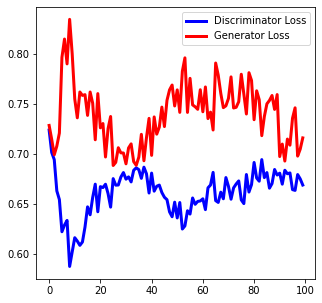

In [9]:
model.plot_losses()